In [7]:
import numpy as np
import pandas as pd


N_FOLDS = 5

folder="cache"

oof_df = pd.read_parquet(f'{folder}/new_oof_shujun_overlap_calc.parquet')
print(oof_df.shape)

oof_df.head()

(35724267, 34)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_24,f_25,id,class,begin,end,kfold,predictionstring,idx,overlap
0,1.0,0.183223,0.185430,0.994907,0.994907,0.994907,0.994907,0.994907,0.994907,0.994907,...,0.002926,0.120611,4AB030046F42,Evidence,83,84,0,83 83,0,0.011628
1,2.0,0.183223,0.187638,0.994907,0.995471,0.996034,0.996597,0.997161,0.997724,0.998287,...,0.002926,0.120611,4AB030046F42,Evidence,83,85,0,83 84,1,0.023256
2,3.0,0.183223,0.189845,0.994907,0.996034,0.997161,0.998287,0.998625,0.998963,0.999300,...,0.002926,0.120611,4AB030046F42,Evidence,83,86,0,83 85,2,0.034884
3,4.0,0.183223,0.192053,0.994907,0.996597,0.998287,0.998794,0.999300,0.999482,0.999665,...,0.002926,0.120611,4AB030046F42,Evidence,83,87,0,83 86,3,0.046512
4,5.0,0.183223,0.194260,0.994907,0.997161,0.998625,0.999300,0.999502,0.999624,0.999665,...,0.002926,0.120611,4AB030046F42,Evidence,83,88,0,83 87,4,0.058140


In [8]:
gt_df = pd.read_csv("../train_folds.csv")
print(gt_df.shape)
gt_df.head()

(144293, 9)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,1
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,1
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,1


In [9]:
oof_df = oof_df.drop("kfold", axis=1).merge(gt_df[["id", "kfold"]].drop_duplicates(), on="id", how="left")

oof_df["kfold"].isnull().mean()

0.0

In [10]:
def calc_overlap_shujun(pred, gt):
    """
    Calculates if the overlap between prediction and
    ground truth is enough fora potential True positive
    """
    try:
        g1=pred[1]+1-gt[0]
        g2=gt[1]+1-pred[0]
        l1=pred[1]-pred[0]+1
        l2=gt[1]-gt[0]+1
        #print(g1,g2)
        if g1*g2>=0:
            #g1=abs(g1)+1
            #g2=abs(g2)+1
            inter=min((g1,g2,l1,l2))#/max((g1,g2,l1,l2))
            overlap_1=inter/l1
            overlap_2=inter/l2
            return overlap_1 >= 0.5 and overlap_2 >= 0.5
        else:
            return False
    except:
        return False


   
    

def score_feedback_comp_micro_shujun(pred_df, gt_df, discourse_type):
    """
    A function that scores for the kaggle
        Student Writing Competition

    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df.loc[gt_df['discourse_type'] == discourse_type,
                      ['id', 'predictionstring']].reset_index(drop=True)
    pred_df = pred_df.loc[pred_df['class'] == discourse_type,
                      ['id', 'predictionstring']].reset_index(drop=True)
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    pred_df['predictionstring'] = [(int(pred.split(' ')[0]),int(pred.split(' ')[-1])) for pred in pred_df['predictionstring']]
    gt_df['predictionstring'] = [(int(pred.split(' ')[0]),int(pred.split(' ')[-1])) for pred in gt_df['predictionstring']]


#     print(pred_df[pred_df['predictionstring']!=pred_df['predictionstring']])
#     exit()
    #gt_strings=

    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on='id',
                           right_on='id',
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    overlaps = [calc_overlap_shujun(*args) for args in zip(list(joined.predictionstring_pred),
                                                     list(joined.predictionstring_gt))]

    # 2. If the overlap between the ground truth and prediction is >= 0.5,
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    # we don't need to compute the match to compute the score
    TP = joined.loc[overlaps]['gt_id'].nunique()

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    TPandFP = len(pred_df)
    TPandFN = len(gt_df)

    #calc microf1
    my_f1_score = 2*TP / (TPandFP + TPandFN)
    return my_f1_score

def score_feedback_comp_shujun(pred_df, gt_df, return_class_scores=False):
    class_scores = {}
    for discourse_type in gt_df.discourse_type.unique():
        class_score = score_feedback_comp_micro_shujun(pred_df, gt_df, discourse_type)
        class_scores[discourse_type] = class_score
    f1 = np.mean([v for v in class_scores.values()])
    if return_class_scores:
        return f1, class_scores
    return f1


In [11]:
from utils import score_feedback_comp


score_feedback_comp_shujun(oof_df[oof_df["f_7"] > 0.9999], gt_df, return_class_scores=True)

(0.0036218261427709672,
 {'Lead': 0.014729167433810805,
  'Position': 0.0,
  'Evidence': 0.010623615565585968,
  'Claim': 0.0,
  'Concluding Statement': 0.0,
  'Counterclaim': 0.0,
  'Rebuttal': 0.0})

In [12]:
oof_df["begin"] = oof_df["predictionstring"].apply(lambda x: int(str(x).split()[0]))
#oof_df["end"] = oof_df["predictionstring"].apply(lambda x: int(str(x).split()[-1]))
#oof_df["len"] = oof_df["end"] - oof_df["begin"] + 1
#oof_df["loc"] = (oof_df["begin"] + oof_df["end"]) / 2

oof_df = oof_df.sort_values(["id", "begin"]).reset_index(drop=True)
oof_df.head(20)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_24,f_25,id,class,begin,end,predictionstring,idx,overlap,kfold
0,1.0,0.0,0.003984,0.955514,0.955514,0.955514,0.955514,0.955514,0.955514,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,1,0 0,25782367,0.0,3
1,2.0,0.0,0.007968,0.855247,0.871958,0.888669,0.905380,0.922092,0.938803,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,2,0 1,25782368,0.0,3
2,3.0,0.0,0.011952,0.855247,0.860892,0.866537,0.872182,0.899959,0.927737,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,3,0 2,25782369,0.0,3
3,4.0,0.0,0.015936,0.855247,0.863714,0.872182,0.878996,0.885810,0.920662,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,4,0 3,25782370,0.0,3
4,5.0,0.0,0.019920,0.855247,0.866537,0.876725,0.885810,0.893285,0.916520,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,5,0 4,25782371,0.0,3
5,6.0,0.0,0.023904,0.855247,0.869359,0.881267,0.891168,0.896692,0.906771,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,6,0 5,25782372,0.0,3
6,7.0,0.0,0.027888,0.855247,0.872182,0.885810,0.892126,0.896526,0.897023,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,7,0 6,25782373,0.0,3
7,8.0,0.0,0.031873,0.855247,0.874453,0.887915,0.894326,0.896857,0.898911,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,8,0 7,25782374,0.0,3
8,9.0,0.0,0.035857,0.855247,0.876725,0.890021,0.896526,0.897342,0.898852,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,9,0 8,25782375,0.0,3
9,10.0,0.0,0.039841,0.855247,0.878996,0.892126,0.896774,0.897980,0.899612,0.955514,...,0.063186,0.256825,0000D23A521A,Lead,0,10,0 9,25782376,0.0,3


In [13]:
oof_df["target"] = oof_df["overlap"] >= 0.5
oof_df["target"].mean()

0.3528075187658854

In [14]:
discourse_types = gt_df["discourse_type"].unique()

In [15]:

#for dtype in discourse_types:
#    oof_df["x"] = oof_df["avg_score"]*(oof_df["class"] == dtype)
#    oof_df[f"sum_{dtype}"] = oof_df.groupby("id")["x"].transform("sum")

#oof_df.drop("x", axis=1, inplace=True)

#oof_df.head()

In [16]:
from tqdm import tqdm
import os

def read_texts(directory):
    names, texts = [], []
    for f in tqdm(list(os.listdir(directory))):
        names.append(f.replace('.txt', ''))
        texts.append(open(directory + f, 'r').read())
    df = pd.DataFrame({'id': names, 'full_text': texts})
    return df

#text_df = read_texts("data/train/")
#print(text_df.shape)
#text_df.head()

#oof_df = oof_df.merge(text_df, on="id", how="left")

#oof_df["loc_rate"] = oof_df["loc"] / oof_df["full_text"].apply(lambda x: len(x.split()))

In [17]:
num_features = {'Lead': 26,
 'Position': 19,
 'Evidence': 19,
 'Claim': 19,
 'Concluding Statement': 19,
 'Counterclaim': 16,
 'Rebuttal': 16}


target = "target"

In [18]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score




param = {'objective': 'reg:logistic',
         'eval_metric': "auc",
         'learning_rate': 0.05,
         'max_depth': 4,
         "min_child_weight": 200,
         "colsample_bynode": 0.8,
         "subsample": 0.5,
         "tree_method": 'gpu_hist', "gpu_id": 0
    }

y_oof = np.zeros(oof_df.shape[0])
res = dict()
best_th = dict()

lvl1_stacking_df = []

for dtype in discourse_types:
    features = [f"f_{i}" for i in range(num_features[dtype])]

    
    all_indices = np.where(oof_df["class"] == dtype)[0]
    discourse_df = oof_df[oof_df["class"] == dtype].reset_index(drop=True)
    
    tm = discourse_df["target"].mean()
    
    param["scale_pos_weight"] = (1 - tm)/tm
    
    best_its = []
    
    print(dtype, len(features))
    for f in range(N_FOLDS):
        val_ind = all_indices[np.where(discourse_df["kfold"] == f)[0]]
        train_df, val_df = discourse_df[discourse_df["kfold"] != f], discourse_df[discourse_df["kfold"] == f]

        d_train = xgb.DMatrix(train_df[features], train_df[target])
        d_val = xgb.DMatrix(val_df[features], val_df[target])

        model = xgb.train(param, d_train, evals=[(d_val, "val")], num_boost_round=2000, verbose_eval=50, 
                          early_stopping_rounds=50)
        model.save_model(f'{folder}/xgb_{dtype}_{f}.json')

        y_oof[val_ind] = model.predict(d_val)
        
        best_its.append(model.best_iteration)
        print("...")
        
    discourse_df["prob"] = y_oof[all_indices]
    discourse_df = discourse_df.sort_values(["id", "prob"], ascending=False).reset_index(drop=True)
    
    print("removing overlaps...")
    
    pred_df = []
    prev_id = -1
    overlap_array = np.zeros(4096)
    for id, ps, cls, prob, overlap in zip(discourse_df["id"].values, discourse_df["predictionstring"].values,
                                 discourse_df["class"].values, discourse_df["prob"].values,
                                 discourse_df["overlap"].values):
        if id != prev_id:
            prev_id = id
            overlap_array = np.zeros(4096)
        
        ps_list = ps.split()
        begin, end = int(ps_list[0]), int(ps_list[-1]) + 1
        
        intersect = np.sum(overlap_array[begin:end])
        total = end - begin
        
        condition = intersect <= 1
        
        if dtype in {"Counterclaim", "Rebuttal"}:
            condition = intersect/total <= 0.2
        
        if condition:
            pred_df.append({"id": id, "class": cls, "prob": prob, "predictionstring": ps, "overlap": overlap})
            overlap_array[begin:end] = 1
    
    pred_df = pd.DataFrame(pred_df)
    lvl1_stacking_df.append(pred_df)
    print("tuning...")
    
    thresholds = np.arange(10, 90, 1)/100
    
    all_gt = gt_df[gt_df["discourse_type"] == dtype].shape[0]
    print(pred_df.shape, all_gt)
    f1s = []
    for t in thresholds:
        tp = (pred_df[pred_df["prob"] > t]["overlap"] >= 0.5).sum()
        fp = (pred_df[pred_df["prob"] > t]["overlap"] < 0.5).sum()
        fn = all_gt - tp
        
        f1 = tp / (tp + (fp + fn)/2)
        
        #print(t, tp, fp, fn)
        
        f1s.append(f1)

    best_ind = np.argmax(f1s)
    print()
    print(thresholds[best_ind], f1s[best_ind])
    print()
    
    best_th[dtype] = thresholds[best_ind]
    res[dtype] = f1s[best_ind]
    
    
    #d_train = xgb.DMatrix(discourse_df[features], discourse_df[target])
    #model = xgb.train(param, d_train, num_boost_round=int(np.mean(best_its)*1.2))
    #model.save_model(f'models/xgb_{dtype}.json')


Lead 26
[0]	val-auc:0.92934
[50]	val-auc:0.95171
[100]	val-auc:0.95734
[150]	val-auc:0.95951
[200]	val-auc:0.96029
[250]	val-auc:0.96080
[300]	val-auc:0.96109
[350]	val-auc:0.96112
[352]	val-auc:0.96111
...
[0]	val-auc:0.93316
[50]	val-auc:0.95605
[100]	val-auc:0.95943
[150]	val-auc:0.96122
[200]	val-auc:0.96184
[250]	val-auc:0.96224
[300]	val-auc:0.96241
[350]	val-auc:0.96260
[400]	val-auc:0.96269
[450]	val-auc:0.96275
[500]	val-auc:0.96276
[550]	val-auc:0.96284
[583]	val-auc:0.96277
...
[0]	val-auc:0.93056
[50]	val-auc:0.95426
[100]	val-auc:0.95942
[150]	val-auc:0.96141
[200]	val-auc:0.96235
[250]	val-auc:0.96269
[300]	val-auc:0.96289
[350]	val-auc:0.96309
[400]	val-auc:0.96314
[450]	val-auc:0.96317
[460]	val-auc:0.96316
...
[0]	val-auc:0.93108
[50]	val-auc:0.95282
[100]	val-auc:0.95760
[150]	val-auc:0.95949
[200]	val-auc:0.96013
[250]	val-auc:0.96041
[300]	val-auc:0.96065
[350]	val-auc:0.96072
[400]	val-auc:0.96070
...
[0]	val-auc:0.92939
[50]	val-auc:0.95078
[100]	val-auc:0.95567
[

[950]	val-auc:0.85466
[1000]	val-auc:0.85474
[1050]	val-auc:0.85485
[1100]	val-auc:0.85498
[1150]	val-auc:0.85501
[1200]	val-auc:0.85512
[1250]	val-auc:0.85520
[1300]	val-auc:0.85526
[1350]	val-auc:0.85534
[1400]	val-auc:0.85538
[1450]	val-auc:0.85537
[1500]	val-auc:0.85537
[1514]	val-auc:0.85533
...
[0]	val-auc:0.78603
[50]	val-auc:0.83030
[100]	val-auc:0.84060
[150]	val-auc:0.84441
[200]	val-auc:0.84657
[250]	val-auc:0.84831
[300]	val-auc:0.84949
[350]	val-auc:0.85039
[400]	val-auc:0.85108
[450]	val-auc:0.85182
[500]	val-auc:0.85240
[550]	val-auc:0.85276
[600]	val-auc:0.85292
[650]	val-auc:0.85319
[700]	val-auc:0.85345
[750]	val-auc:0.85364
[800]	val-auc:0.85377
[850]	val-auc:0.85393
[900]	val-auc:0.85407
[950]	val-auc:0.85419
[1000]	val-auc:0.85430
[1050]	val-auc:0.85439
[1100]	val-auc:0.85442
[1150]	val-auc:0.85446
[1200]	val-auc:0.85450
[1250]	val-auc:0.85456
[1300]	val-auc:0.85463
[1350]	val-auc:0.85466
[1400]	val-auc:0.85473
[1450]	val-auc:0.85474
[1500]	val-auc:0.85478
[1550]	v

In [19]:
best_th

{'Lead': 0.58,
 'Position': 0.58,
 'Evidence': 0.53,
 'Claim': 0.54,
 'Concluding Statement': 0.6,
 'Counterclaim': 0.71,
 'Rebuttal': 0.73}

In [20]:
res

{'Lead': 0.8680504077094143,
 'Position': 0.7589691420820617,
 'Evidence': 0.7746043093145085,
 'Claim': 0.6733560800306878,
 'Concluding Statement': 0.872833008207884,
 'Counterclaim': 0.594061135371179,
 'Rebuttal': 0.5278546904419094}

In [21]:
sum(res.values()) / len(res) # 7020

0.7242469675939492

In [22]:
lvl1_stacking_df = pd.concat(lvl1_stacking_df)
lvl1_stacking_df.shape

(434437, 5)

In [23]:
score_feedback_comp_shujun(lvl1_stacking_df[lvl1_stacking_df["prob"] > lvl1_stacking_df["class"].map(best_th)], 
                    gt_df, return_class_scores=True)

(0.7230779375552113,
 {'Lead': 0.8680504077094143,
  'Position': 0.7587656832824686,
  'Evidence': 0.7747383470908218,
  'Claim': 0.6693787728897055,
  'Concluding Statement': 0.872833008207884,
  'Counterclaim': 0.5921397379912664,
  'Rebuttal': 0.5256396057149186})

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

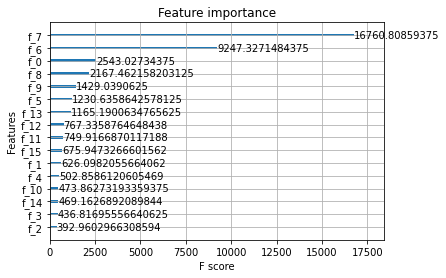

In [24]:
xgb.plot_importance(model, importance_type="gain")

In [25]:
len(oof_df["id"].unique())

15593

In [26]:
len(gt_df["id"].unique())

15594

In [27]:
lvl1_stacking_df.to_parquet(f"{folder}/level1_oof.parquet", index=False)

In [28]:
lvl1_stacking_df.sort_values("prob")

,id,class,prob,predictionstring,overlap
8376,F3EE1510C8EF,Evidence,0.000017,174 174,0.004310
12703,EDDFFD34DBD4,Evidence,0.000018,361 361,0.007042
129113,443033444A5F,Evidence,0.000018,379 379,0.002079
82151,89BED1950DFE,Evidence,0.000020,120 120,0.013514
74306,94A8B4DE1712,Evidence,0.000020,83 83,0.005814
...,...,...,...,...,...
7990,EFB0DDC8EA77,Claim,0.999402,92 109,0.947368
51425,9627B47C10DE,Claim,0.999425,187 192,0.857143
111055,1C9F99DCD7E1,Claim,0.999433,81 100,1.000000
29631,C236576483D8,Claim,0.999481,107 124,1.000000
